<a href="https://colab.research.google.com/github/hariprasad59/Garbage-Iamge-Classification/blob/main/GarbageImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hariprasadmmmm","key":"1d91e061f933afb11a5e5c70bcc86e66"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d asdasdasasdas/garbage-classification


Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.14GB/s]


In [ ]:
!unzip -q garbage-classification.zip -d garbage_dataset


In [ ]:
import os
import shutil
import random
from pathlib import Path

SRC_DIR = Path("garbage_dataset/Garbage classification/Garbage classification")
DEST_DIR = Path("data")

random.seed(42)

train_ratio, val_ratio = 0.8, 0.1

for cls in os.listdir(SRC_DIR):
    cls_path = SRC_DIR / cls
    if not cls_path.is_dir():
        continue

    images = list(cls_path.iterdir())
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split, files in splits.items():
        split_dir = DEST_DIR / split / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        for img in files:
            shutil.copy(img, split_dir / img.name)

print("✅ Dataset split completed")

✅ Dataset split completed


In [ ]:
import os
from pathlib import Path
from collections import Counter

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

# ======================
# 1. BASIC CONFIG
# ======================
DATA_DIR = Path("data")  # change if your folder is named differently
IMG_SIZE = 224
BATCH_SIZE = 32

# ======================
# 2. TRANSFORMS
#    - Resize to 224x224
#    - Normalize pixels
#    - Add augmentation ONLY to train
# ======================

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    # Normalization with ImageNet stats (for ResNet/MobileNet/EfficientNet)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ======================
# 3. DATASETS
# ======================

train_dataset = datasets.ImageFolder(DATA_DIR / "train", transform=train_transform)
val_dataset   = datasets.ImageFolder(DATA_DIR / "val",   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(DATA_DIR / "test",  transform=val_test_transform)

print("Classes:", train_dataset.classes)

# ======================
# 4. CLASS IMBALANCE HANDLING
#    - Compute class counts
#    - Create WeightedRandomSampler for train loader
# ======================

# count samples per class
labels = [label for _, label in train_dataset.samples]
class_counts = Counter(labels)
num_classes = len(class_counts)
print("Class counts (by index):", class_counts)

# weight for each class: inverse frequency
class_weights = {cls_idx: len(train_dataset) / count
                 for cls_idx, count in class_counts.items()}

# weight for each sample
sample_weights = [class_weights[label] for label in labels]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# ======================
# 5. DATALOADERS
# ======================

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,       # handles imbalance
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class counts (by index): Counter({3: 475, 1: 400, 4: 385, 2: 328, 0: 322, 5: 109})
Train batches: 64
Val batches: 8
Test batches: 9


Class counts: {'plastic': 385, 'cardboard': 322, 'trash': 109, 'paper': 475, 'glass': 400, 'metal': 328}


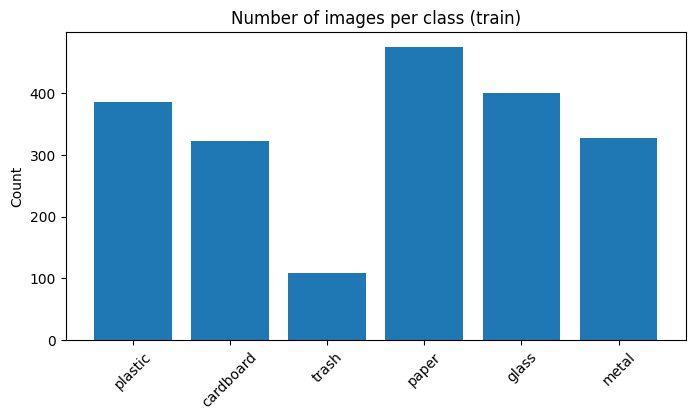

In [ ]:
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

BASE_DIR = Path("data")              # change if needed
TRAIN_DIR = BASE_DIR / "train"

class_counts = {}
for class_dir in TRAIN_DIR.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        num_images = len(list(class_dir.glob("*")))
        class_counts[class_name] = num_images

print("Class counts:", class_counts)

# Bar plot
plt.figure(figsize=(8,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of images per class (train)")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


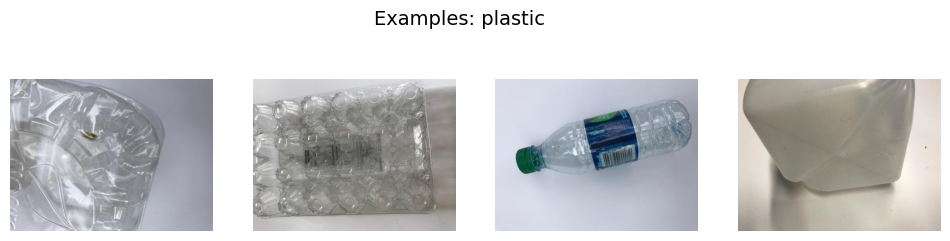

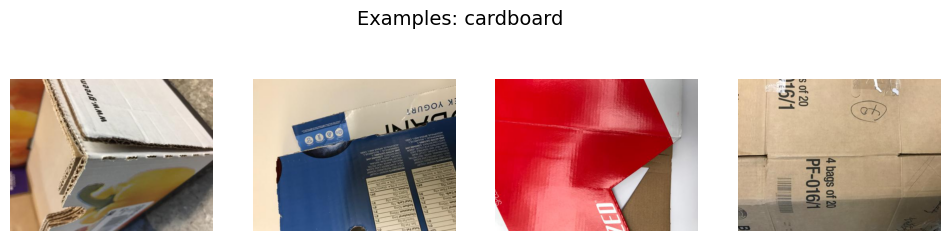

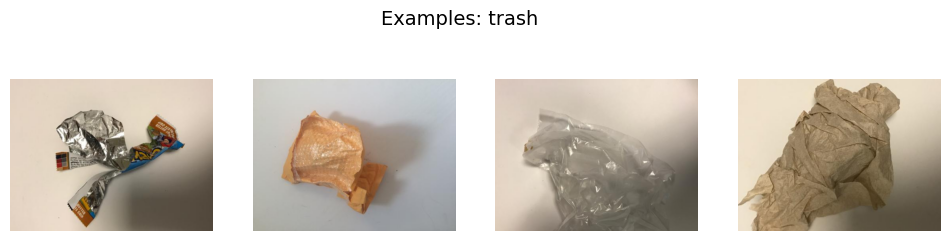

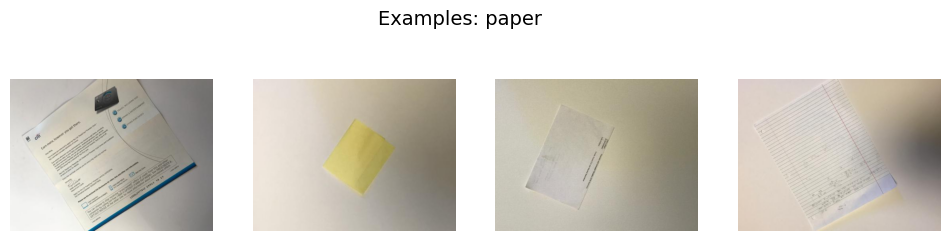

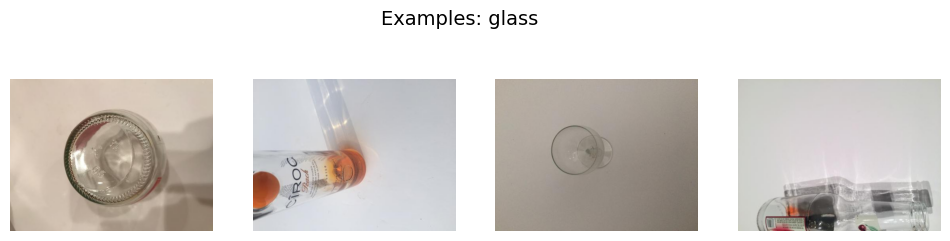

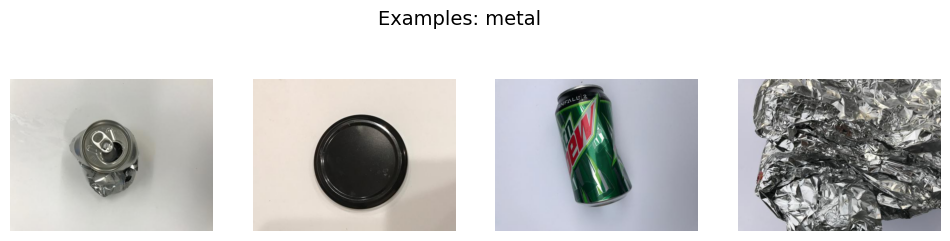

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

n_per_class = 4   # how many images to show per class

for class_dir in TRAIN_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    class_name = class_dir.name
    image_paths = list(class_dir.glob("*"))[:n_per_class]

    if not image_paths:
        continue

    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Examples: {class_name}", fontsize=14)

    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert("RGB")
        ax = plt.subplot(1, n_per_class, i+1)
        ax.imshow(img)
        ax.axis("off")

    plt.show()


Using 500 images for stats


100%|██████████| 500/500 [00:12<00:00, 39.86it/s]


Approx channel means (R,G,B): [0.66880037 0.64692475 0.62466199]
Approx channel stds  (R,G,B): [0.16198042 0.1542761  0.1649307 ]


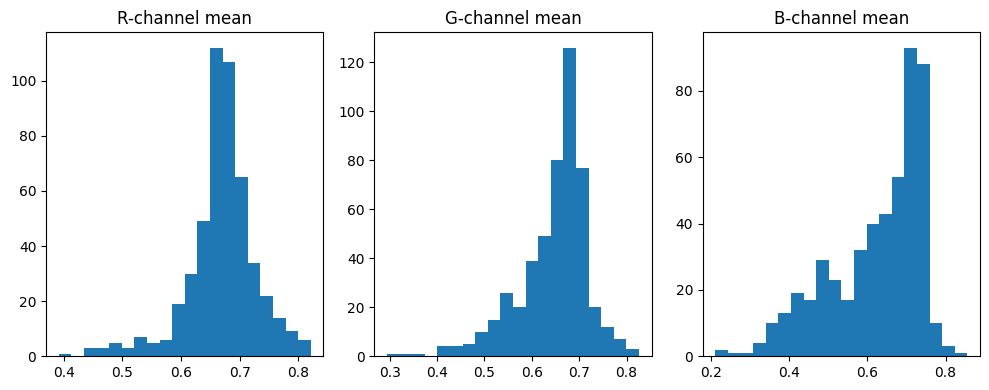

In [ ]:
import numpy as np
from tqdm import tqdm

all_means = []
all_stds = []

# use a subset if dataset is big
max_images = 500

image_files = []
for class_dir in TRAIN_DIR.iterdir():
    if class_dir.is_dir():
        image_files.extend(list(class_dir.glob("*")))

image_files = image_files[:max_images]
print(f"Using {len(image_files)} images for stats")

for img_path in tqdm(image_files):
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img) / 255.0      # scale 0–1
    # H x W x 3 -> compute per-channel stats
    all_means.append(arr.mean(axis=(0,1)))
    all_stds.append(arr.std(axis=(0,1)))

all_means = np.stack(all_means)
all_stds = np.stack(all_stds)

mean_rgb = all_means.mean(axis=0)
std_rgb = all_stds.mean(axis=0)

print("Approx channel means (R,G,B):", mean_rgb)
print("Approx channel stds  (R,G,B):", std_rgb)

# Histograms
plt.figure(figsize=(10,4))
for i, color in enumerate(["R", "G", "B"]):
    plt.subplot(1,3,i+1)
    plt.hist(all_means[:, i], bins=20)
    plt.title(f"{color}-channel mean")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/garbage_model/


In [ ]:
# Step-4: Transfer Learning training script (ResNet50 or MobileNetV2)
# Paste & run in Colab. Expects data/train, data/val folders (ImageFolder layout).
# Saves best checkpoint to ./models/best_model.pth

import os
from pathlib import Path
import time
import copy
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# -----------------------
# Config
# -----------------------
DATA_DIR = Path("data")
MODEL_NAME = "resnet50"         # options: "resnet50" or "mobilenet_v2"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12
LR = 1e-4
WEIGHT_DECAY = 1e-4
FREEZE_BASE = True              # freeze backbone initially
UNFREEZE_AFTER = None           # e.g., 4 to unfreeze after 4 epochs; or None to never unfreeze
CHECKPOINT_DIR = Path("/content/drive/MyDrive/garbage_model/")
CHECKPOINT_DIR.mkdir(exist_ok=True)
CHECKPOINT_PATH = CHECKPOINT_DIR / "best_model.pth"
NUM_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# Dataloaders (use existing if present in workspace)
# -----------------------
try:
    # if user already created train_loader/val_loader in previous cells, reuse them
    train_loader
    val_loader
    print("Using existing train_loader/val_loader from workspace.")
except NameError:
    print("Creating dataloaders from disk:", DATA_DIR)
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize(int(IMG_SIZE*1.15)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

    train_dataset = datasets.ImageFolder(DATA_DIR / "train", transform=train_transform)
    val_dataset   = datasets.ImageFolder(DATA_DIR / "val", transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    class_to_idx = train_dataset.class_to_idx
    print("Classes:", train_dataset.classes)

# -----------------------
# Build model helper
# -----------------------
def build_model(name, num_classes, pretrained=True):
    if name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    elif name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=pretrained)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    else:
        raise ValueError("Model not supported")
    return model

# -----------------------
# Prepare model, criterion, optimizer
# -----------------------
num_classes = len(getattr(train_loader.dataset, "classes", train_loader.dataset.classes))
model = build_model(MODEL_NAME, num_classes, pretrained=True)
model = model.to(device)

# Freeze base layers if requested
if FREEZE_BASE:
    for name, param in model.named_parameters():
        param.requires_grad = False
    # enable classifier parameters
    if MODEL_NAME == "resnet50":
        for param in model.fc.parameters():
            param.requires_grad = True
    else:  # mobilenet
        for param in model.classifier.parameters():
            param.requires_grad = True
    print("Backbone frozen; classifier unfrozen.")
else:
    for param in model.parameters():
        param.requires_grad = True
    print("All layers set to requires_grad=True")

# Class weights (handle imbalance) - compute from train dataset
try:
    labels = [s[1] for s in train_loader.dataset.samples]
    counts = np.bincount(labels)
    class_weights = torch.tensor((len(labels) / (len(counts) * counts)), dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print("Using class-weighted CrossEntropyLoss.")
except Exception as e:
    print("Could not compute class weights, using plain CrossEntropyLoss. Error:", e)
    criterion = nn.CrossEntropyLoss()

# Optimizer - only params with requires_grad=True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

# mixed precision scaler
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# -----------------------
# Training & validation loops
# -----------------------
def validate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            running_loss += loss.item() * imgs.size(0)
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, f1

best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    epoch_samples = 0
    start = time.time()

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item() * imgs.size(0)
        epoch_samples += imgs.size(0)

    train_loss = epoch_loss / epoch_samples
    val_loss, val_acc, val_f1 = validate(model, val_loader)

    scheduler.step(val_f1)

    elapsed = time.time() - start
    print(f"Epoch [{epoch}/{EPOCHS}]  train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}  val_f1: {val_f1:.4f}  time:{elapsed:.1f}s")

    # Save best
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save({
            "model_state_dict": best_model_wts,
            "class_to_idx": getattr(train_loader.dataset, "class_to_idx", None),
            "model_name": MODEL_NAME
        }, CHECKPOINT_PATH)
        print(f"Saved best model (f1={best_f1:.4f}) to {CHECKPOINT_PATH}")

    # Optionally unfreeze after N epochs (fine-tune)
    if UNFREEZE_AFTER is not None and epoch == UNFREEZE_AFTER:
        print("Unfreezing backbone for fine-tuning.")
        for param in model.parameters():
            param.requires_grad = True
        # re-create optimizer with lower LR for fine-tuning
        optimizer = optim.Adam(model.parameters(), lr=LR/5, weight_decay=WEIGHT_DECAY)
        scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# restore best weights
model.load_state_dict(best_model_wts)
print("Training complete. Best val macro-F1:", best_f1)

# Save final model_state_dict (smaller than checkpoint with full state)
final_path = CHECKPOINT_DIR / "final_model.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "class_to_idx": getattr(train_loader.dataset, "class_to_idx", None),
    "model_name": MODEL_NAME
}, final_path)
print("Saved final model to", final_path)

# Save class_to_idx mapping in a json for easy loading in Streamlit
try:
    ctj = train_loader.dataset.class_to_idx
    with open(CHECKPOINT_DIR / "class_to_idx.json", "w") as f:
        json.dump(ctj, f)
    print("Saved class_to_idx.json")
except Exception:
    pass

# Quick test: load best checkpoint and print sample predictions (optional)
# To load for inference later:
# state = torch.load(CHECKPOINT_PATH, map_location=device)
# model_name_saved = state.get("model_name", MODEL_NAME)
# model_loaded = build_model(model_name_saved, num_classes, pretrained=False)
# model_loaded.load_state_dict(state["model_state_dict"])
# model_loaded.to(device).eval()


Device: cpu
Using existing train_loader/val_loader from workspace.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]
/tmp/ipython-input-2649582211.py:140: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


Backbone frozen; classifier unfrozen.
Using class-weighted CrossEntropyLoss.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [1/12]  train_loss: 1.4650  val_loss: 1.5334  val_acc: 0.2191  val_f1: 0.2508  time:679.1s
Saved best model (f1=0.2508) to /content/drive/MyDrive/garbage_model/best_model.pth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [2/12]  train_loss: 1.0806  val_loss: 0.9804  val_acc: 0.6853  val_f1: 0.6698  time:670.1s
Saved best model (f1=0.6698) to /content/drive/MyDrive/garbage_model/best_model.pth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [3/12]  train_loss: 0.8821  val_loss: 0.8339  val_acc: 0.7131  val_f1: 0.7014  time:663.7s
Saved best model (f1=0.7014) to /content/drive/MyDrive/garbage_model/best_model.pth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [4/12]  train_loss: 0.8013  val_loss: 0.6965  val_acc: 0.7928  val_f1: 0.7743  time:660.9s
Saved best model (f1=0.7743) to /content/drive/MyDrive/garbage_model/best_model.pth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [5/12]  train_loss: 0.7426  val_loss: 0.6504  val_acc: 0.8008  val_f1: 0.7839  time:661.8s
Saved best model (f1=0.7839) to /content/drive/MyDrive/garbage_model/best_model.pth


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [6/12]  train_loss: 0.6931  val_loss: 0.6519  val_acc: 0.7888  val_f1: 0.7690  time:642.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [7/12]  train_loss: 0.6836  val_loss: 0.6505  val_acc: 0.7649  val_f1: 0.7506  time:636.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [8/12]  train_loss: 0.6223  val_loss: 0.6203  val_acc: 0.7729  val_f1: 0.7543  time:639.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [9/12]  train_loss: 0.6047  val_loss: 0.5305  val_acc: 0.8008  val_f1: 0.7812  time:638.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [10/12]  train_loss: 0.6041  val_loss: 0.6114  val_acc: 0.7729  val_f1: 0.7587  time:638.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [11/12]  train_loss: 0.5966  val_loss: 0.5654  val_acc: 0.7809  val_f1: 0.7693  time:642.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2649582211.py:180: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-2649582211.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch [12/12]  train_loss: 0.6053  val_loss: 0.5628  val_acc: 0.7968  val_f1: 0.7787  time:639.3s
Training complete. Best val macro-F1: 0.783890806112603
Saved final model to /content/drive/MyDrive/garbage_model/final_model.pth
Saved class_to_idx.json


Device: cpu
Checkpoint: /content/drive/MyDrive/garbage_model/best_model.pth
Data dir (test): data/test
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] Num classes: 6
Total test images: 257


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded model: resnet50
ckpt class_to_idx: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Acc: 0.8016
Macro F1: 0.7860   Micro F1: 0.8016
Macro Precision: 0.7959   Macro Recall: 0.8313

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.9474    0.8780    0.9114        41
       glass     0.8780    0.7059    0.7826        51
       metal     0.7400    0.9024    0.8132        41
       paper     0.9583    0.7667    0.8519        60
     plastic     0.8571    0.7347    0.7912        49
       trash     0.3947    1.0000    0.5660        15

    accuracy                         0.8016       257
   macro avg     0.7959    0.8313    0.7860       257
weighted avg     0.8536    0.8016    0.8132       257



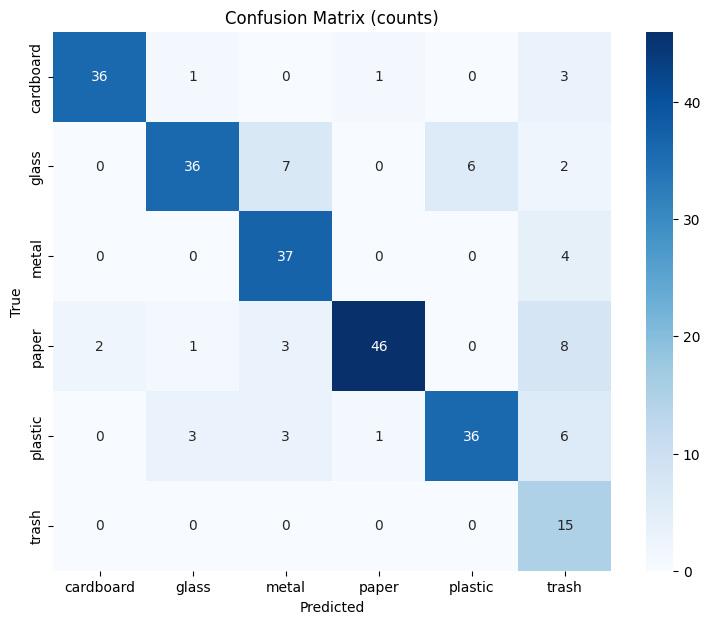

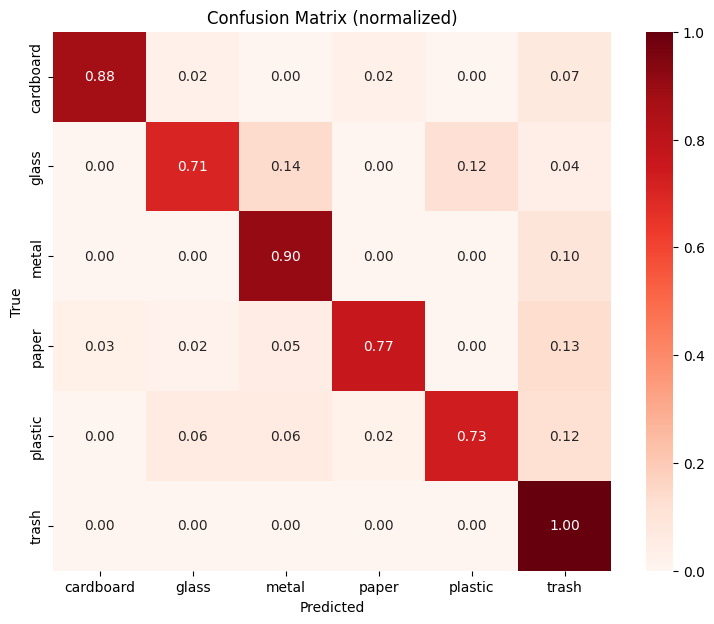

Total misclassified: 51 / 257


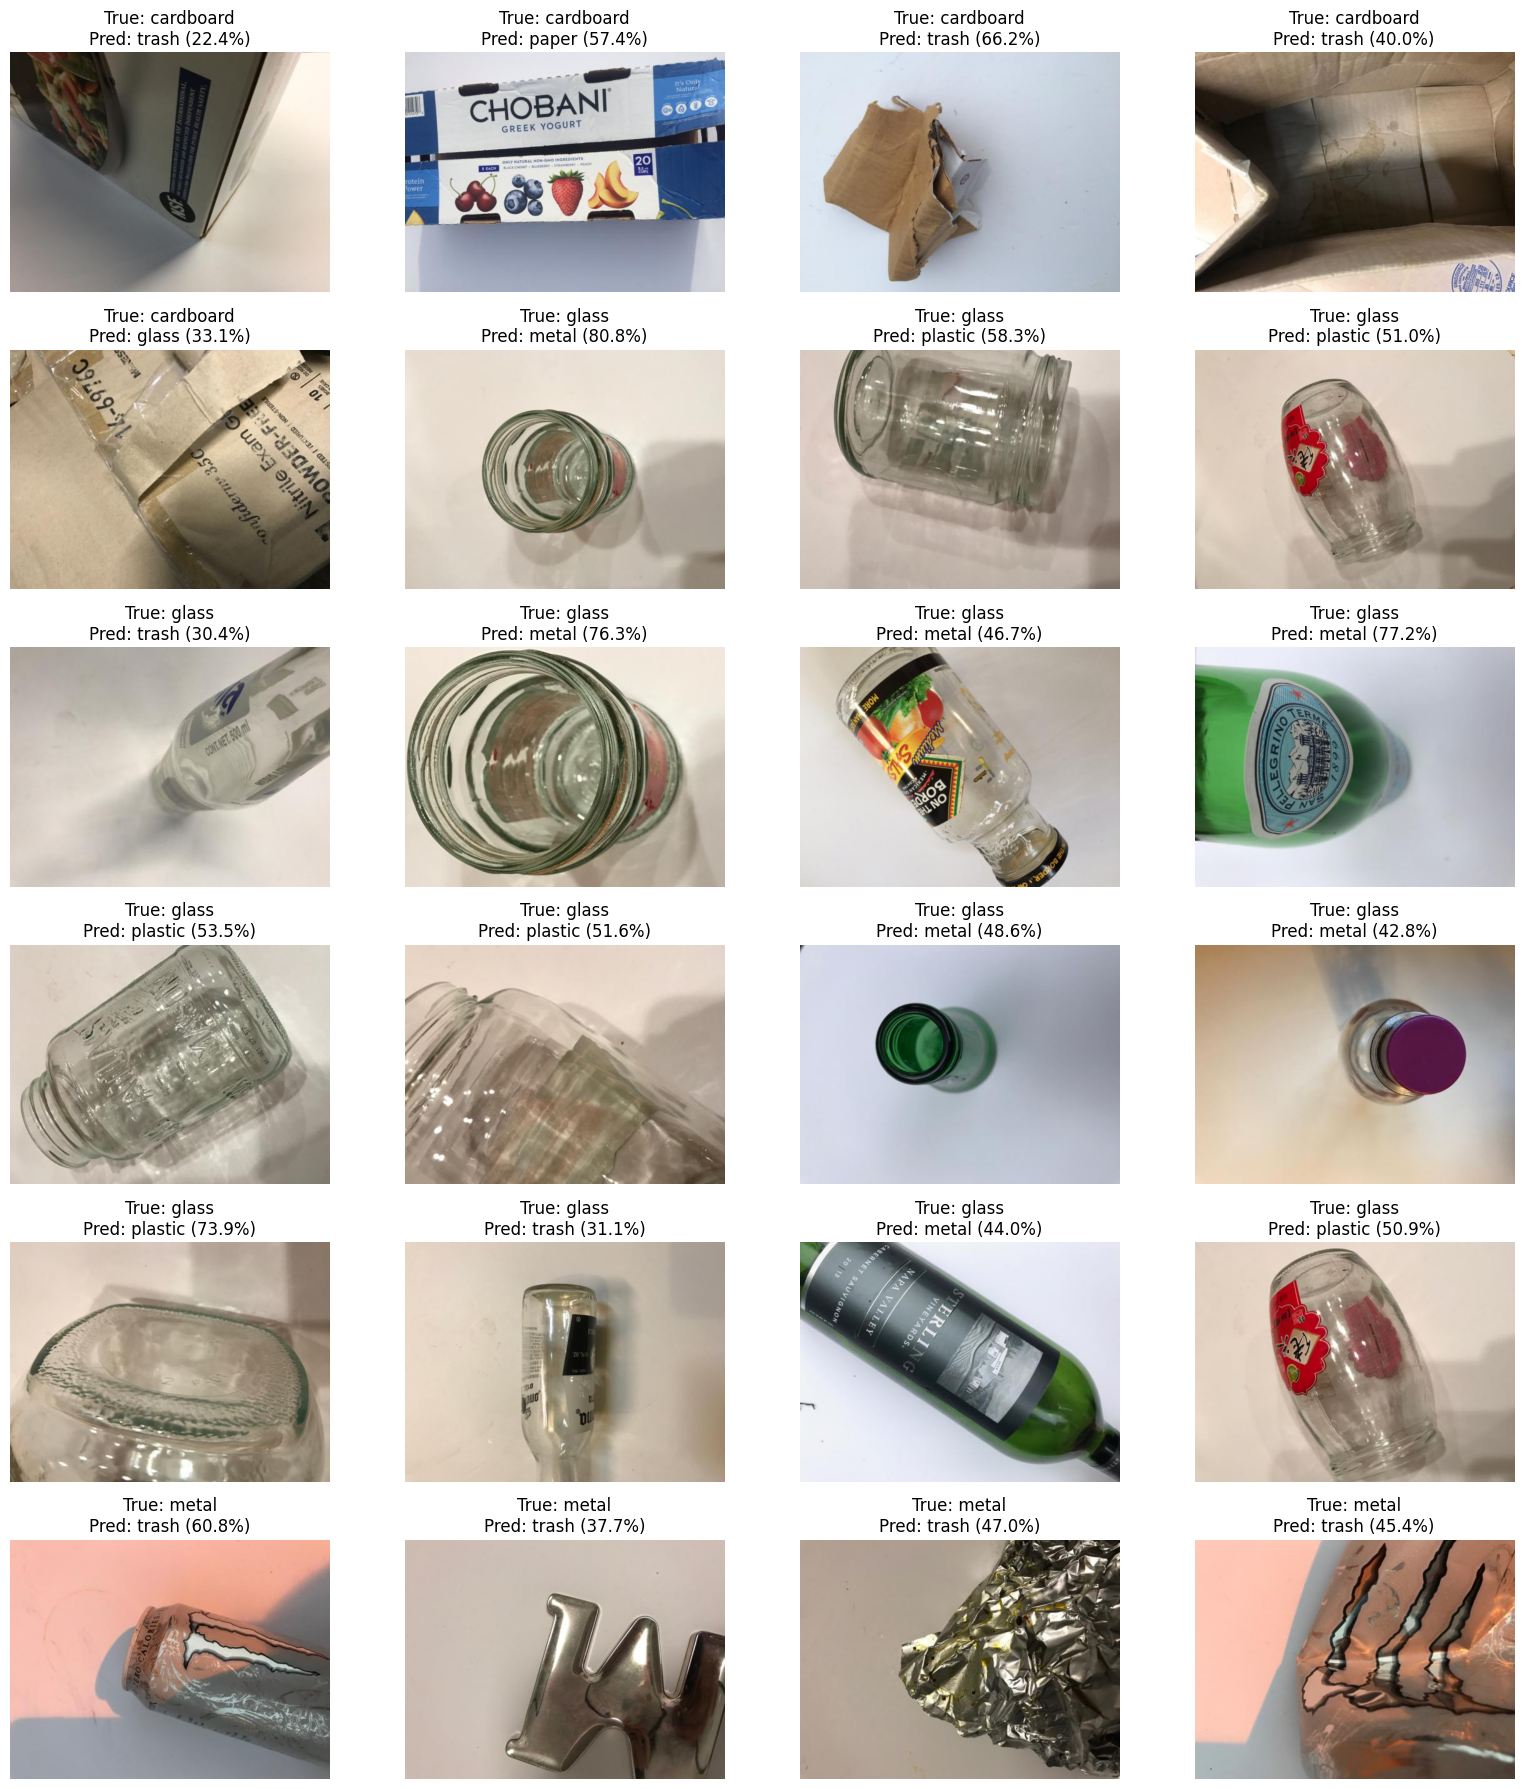

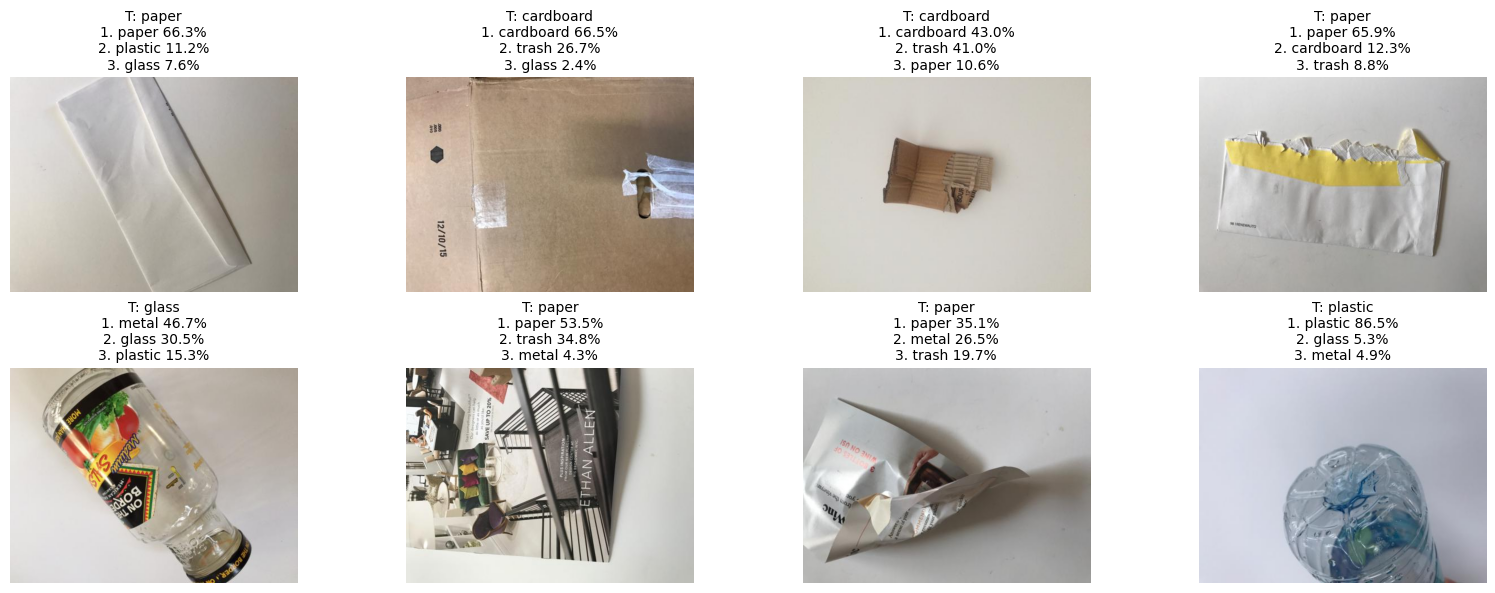

1495

In [ ]:
# Step-5: Evaluation (PyTorch) — run in Colab after training
# Requirements: sklearn, matplotlib, seaborn, torch, torchvision, PIL
import json, os
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# -----------------------
# CONFIG - change these if needed
# -----------------------
DATA_DIR = Path("data/test")               # test folder with class subfolders
CHECKPOINT_PATH = Path("/content/drive/MyDrive/garbage_model/best_model.pth")  # path to saved checkpoint (or final_model.pth)
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_MISCLASS = 24   # number of misclassified images to display
TOPK = 3            # top-K predictions to show

print("Device:", DEVICE)
print("Checkpoint:", CHECKPOINT_PATH)
print("Data dir (test):", DATA_DIR)

# -----------------------
# TRANSFORM (same as used in training val/test)
# -----------------------
test_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# -----------------------
# LOAD DATASET & DATALOADER
# -----------------------
test_dataset = datasets.ImageFolder(DATA_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

class_names = test_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names, "Num classes:", num_classes)
print("Total test images:", len(test_dataset))

# -----------------------
# HELPER: Build same model used in training
# -----------------------
def build_model_by_name(model_name, num_classes, pretrained=False):
    """
    Builds the same model architecture used in training:
    - resnet50: replace model.fc with the same sequential head used during training
    - mobilenet_v2: replace model.classifier with the same sequential head used during training
    """
    if model_name.lower() == "resnet50":
        m = models.resnet50(pretrained=pretrained)
        in_features = m.fc.in_features
        # MATCH the training head: Dropout -> Linear(,512) -> ReLU -> Dropout -> Linear(512,num_classes)
        m.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    elif model_name.lower() == "mobilenet_v2":
        m = models.mobilenet_v2(pretrained=pretrained)
        in_features = m.classifier[1].in_features
        m.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    else:
        raise ValueError("Unsupported model in evaluation: " + str(model_name))
    return m

# -----------------------
# LOAD CHECKPOINT
# -----------------------
state = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

# checkpoint may be dict with model_state_dict and model_name and class_to_idx
if isinstance(state, dict) and "model_state_dict" in state:
    ckpt = state
    model_name_saved = ckpt.get("model_name", "resnet50")
    class_to_idx = ckpt.get("class_to_idx", None)
    model = build_model_by_name(model_name_saved, num_classes, pretrained=False)
    model.load_state_dict(ckpt["model_state_dict"])
else:
    # state is raw state_dict
    model_name_saved = "resnet50"   # change if needed
    model = build_model_by_name(model_name_saved, num_classes, pretrained=False)
    model.load_state_dict(state)

model = model.to(DEVICE)
model.eval()
print("Loaded model:", model_name_saved)

# If checkpoint contains class_to_idx mapping and your test dataset classes are out of order,
# you may want to re-map indices. We assume test dataset classes order matches training's class_to_idx.
if class_to_idx is not None:
    # convert class_to_idx to idx_to_class
    idx_to_class = {v:k for k,v in class_to_idx.items()}
    # print mapping
    print("ckpt class_to_idx:", class_to_idx)
    # WARNING: torchvision.datasets.ImageFolder assigns classes in alphabetical order by default.
    # Ensure mapping is consistent. If needed, update 'class_names' mapping or reorder predictions accordingly.

# -----------------------
# INFERENCE on test set (collect predictions + probs)
# -----------------------
all_preds = []
all_probs = []
all_labels = []
all_paths = []

softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for batch in test_loader:
        imgs, labels = batch
        paths = [p for p, _ in getattr(test_dataset, 'samples', [])]  # not used per-batch
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)                       # logits
        probs = softmax(outputs).cpu().numpy()     # batch x num_classes
        preds = np.argmax(probs, axis=1)
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.numpy().tolist())

# -----------------------
# METRICS
# -----------------------
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")
micro_f1 = f1_score(all_labels, all_preds, average="micro")
macro_precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
macro_recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"Test Acc: {acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}   Micro F1: {micro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}   Macro Recall: {macro_recall:.4f}\n")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))

# -----------------------
# CONFUSION MATRIX (counts)
# -----------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (counts)")
plt.show()

# Normalized confusion matrix (rows sum to 1)
cm_norm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
plt.figure(figsize=(9,7))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (normalized)")
plt.show()

# -----------------------
# Show misclassified examples with top-1 conf
# -----------------------
# We need image file paths in same order as test_dataset.samples: (path, class_idx)
sample_list = test_dataset.samples  # list of (path, label)
misclassified = []
for i, (path_label) in enumerate(sample_list):
    path, true_label = path_label
    pred_label = all_preds[i]
    prob = all_probs[i][pred_label]
    if pred_label != true_label:
        misclassified.append((path, true_label, pred_label, prob, all_probs[i]))

print(f"Total misclassified: {len(misclassified)} / {len(test_dataset)}")

# display up to NUM_MISCLASS misclassified images
n_show = min(NUM_MISCLASS, len(misclassified))
if n_show > 0:
    cols = 4
    rows = (n_show + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for i, (path, true_label, pred_label, prob, probs) in enumerate(misclassified[:n_show]):
        img = Image.open(path).convert("RGB")
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({prob*100:.1f}%)")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications to show. Nice!")

# -----------------------
# Show top-K predictions for a few random test images
# -----------------------
import random
sample_idxs = random.sample(range(len(test_dataset)), min(8, len(test_dataset)))
plt.figure(figsize=(16,6))
for i, idx in enumerate(sample_idxs):
    img_path, label = test_dataset.samples[idx]
    img = Image.open(img_path).convert("RGB")
    probs = np.array(all_probs[idx])
    topk_idx = probs.argsort()[-TOPK:][::-1]
    topk = [(class_names[k], probs[k]) for k in topk_idx]

    ax = plt.subplot(2, 4, i+1)
    ax.imshow(img)
    title_lines = [f"T: {class_names[label]}"]
    for rank, (cname, p) in enumerate(topk, start=1):
        title_lines.append(f"{rank}. {cname} {p*100:.1f}%")
    ax.set_title("\n".join(title_lines), fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

# -----------------------
# Save metrics to JSON (optional)
# -----------------------
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
metrics = {
    "accuracy": acc,
    "macro_f1": macro_f1,
    "micro_f1": micro_f1,
    "macro_precision": macro_precision,
    "macro_recall": macro_recall,
    "classification_report": report
}
SAVE_DIR = Path("/content/drive/MyDrive/garbage_model")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

(SAVE_DIR / "eval_metrics.json").write_text(
    json.dumps(metrics, indent=2)
)


In [ ]:
import json
from pathlib import Path

MODEL_DIR = Path("/content/drive/MyDrive/garbage_model")

model_reports = {}

for file in MODEL_DIR.glob("*eval*.json"):
    with open(file) as f:
        data = json.load(f)
        model_reports[file.stem] = data["macro_f1"]

if not model_reports:
    print("No evaluation files found.")
else:
    print("Model F1-scores:")
    for model, f1 in model_reports.items():
        print(f"{model}: {f1:.4f}")

    best_model = max(model_reports, key=model_reports.get)
    print("\nBest Model:", best_model)


Model F1-scores:
eval_metrics: 0.7860

✅ Best Model: eval_metrics
